In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import matplotlib.pyplot as plt
import matplotlib
import h5py
import numpy as np
%matplotlib inline

import sys,os
#sys.path.insert(0,'/home/yfantaye/ylib/py')
import pysax

import SAX_transform as tsax

In [4]:
def my_concat(sax_intensity,no_bins):
    n = len(sax_intensity)*no_bins
    sax_array_i = np.empty(n)
    k = 0
    for i in range(len(sax_intensity)):
        for j in range(no_bins):
            sax_array_i[k] = sax_intensity[i][j]
            k+=1
    return sax_array_i

def saxize(data,mask,window,no_bins):
    
    window = data.shape[1]
    sax = pysax.SAXModel(window = window,stride = window,nbins = no_bins,alphabet = '12345678')
    msax = pysax.SAXModel(window = window,stride = window,nbins = no_bins,alphabet = '012')
    
    sax_array = np.empty(shape=[len(data),no_bins])
    mask_array = np.empty(shape=[len(mask),no_bins],dtype=bool)
    for i in range(len(data)):
        sax_intensity = sax.symbolize_signal(data[i,:])
        sax_array[i,:] = my_concat(sax_intensity,no_bins)

        mask_intensity = msax.symbolize_signal(mask[i,:])
        ma = my_concat(mask_intensity,no_bins)
        if np.shape(np.where(ma==2))[1] != 0:
            index0=np.where(ma==0)
            index1=np.where(ma==1)
            index2=np.where(ma==2)
            mask_array[i,:][index0] = False
            mask_array[i,:][index1] = False
            mask_array[i,:][index2] = True
        else:
            index1=np.where(ma==0)
            index2=np.where(ma==1)
            mask_array[i,:][index1] = False
            mask_array[i,:][index2] = True
    return sax_array,mask_array

In [46]:
def converter(filename,output,nfrac=None,**kwargs):
    with h5py.File(filename,"r") as fp: 
        data = fp['data'].value
        mask = fp['mask'].value
        freq = fp['frequencies'].value
        time = fp['time'].value
        ra = fp['ra'].value
        dec = fp['dec'].value
        ref_channel = fp['ref_channel'].value

    if nfrac is None:
        sax_data,sax_mask,sax_time = tsax.saxize(data,mask,time,                                                 
                                             **kwargs)
    else:
        if nfrac>1: raise 'nfrac must be between 0 and 1'
        nbin=np.int(len(time)*nfrac)
        sax_data,sax_mask,slide_window = tsax.saxize(data,mask,nbins=nbin,                                                 
                                             **kwargs)
        
    sax_time=slide_window(time)
        
    with h5py.File(output, "w") as fp:
        fp["data"] = sax_data
        fp["mask"] = sax_mask
        fp["frequencies"] = freq
        fp["time"] = sax_time
        fp["ra"] = slide_window(ra)
        fp["dec"] = slide_window(dec)
        fp["ref_channel"] = ref_channel

In [6]:
import glob
# sim_files = glob.glob('../../scratch/hide_sim_March2016/seek_cache/*')
sim_files = glob.glob('../data/hide_sim_30days_seeked/*')
sim_files[0]

'../data/hide_sim_30days_seeked/TEST_MP_PXX_20160302_000000.h5'

In [47]:
window=0
stride=0
nfrac=0.25
nbin='{}'.format(np.int(nfrac*100))
fsax_key='../data/sax/sax{}'.format(nbin)

for i,filename in enumerate(sim_files[0:1]):
    basename=os.path.basename(filename)
    fout=fsax_key+'_'+basename
    print('fout',fout)
    converter(filename,fout,window=window,stride=stride,nfrac=nfrac) #,parallel='joblib'

('fout', '../data/sax/sax25_TEST_MP_PXX_20160302_000000.h5')
('data.shape', (276, 14400))
('window, stride', 14400, 14400)
('ny,nbins=', 276, 3600)
('loop=', 0, [4, 4, 4, 5, 5, 4, 8, 4, 4, 5, 4, 4], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0])
('loop=', 50, [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0.0, 1.0, 0.0, 0.75, 0.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
('loop=', 100, [4, 4, 4, 1, 5, 4, 4, 6, 8, 4, 4, 4], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
('loop=', 150, [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0])
('loop=', 200, [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0])
('loop=', 250, [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0])


In [48]:
with h5py.File(sim_files[0],"r") as fp: 
    data = fp['data'].value
    mask = fp['mask'].value
    freq = fp['frequencies'].value
    time = fp['time'].value
    ra = fp['ra'].value
    dec = fp['dec'].value
    ref_channel = fp['ref_channel'].value
    
   
with h5py.File(fout,"r") as fp: 
    sax_data = fp['data'].value
    sax_mask = fp['mask'].value
    freq = fp['frequencies'].value
    sax_time = fp['time'].value
    sax_ra = fp['ra'].value
    sax_dec = fp['dec'].value
    ref_channel = fp['ref_channel'].value
   


(276, 14400)


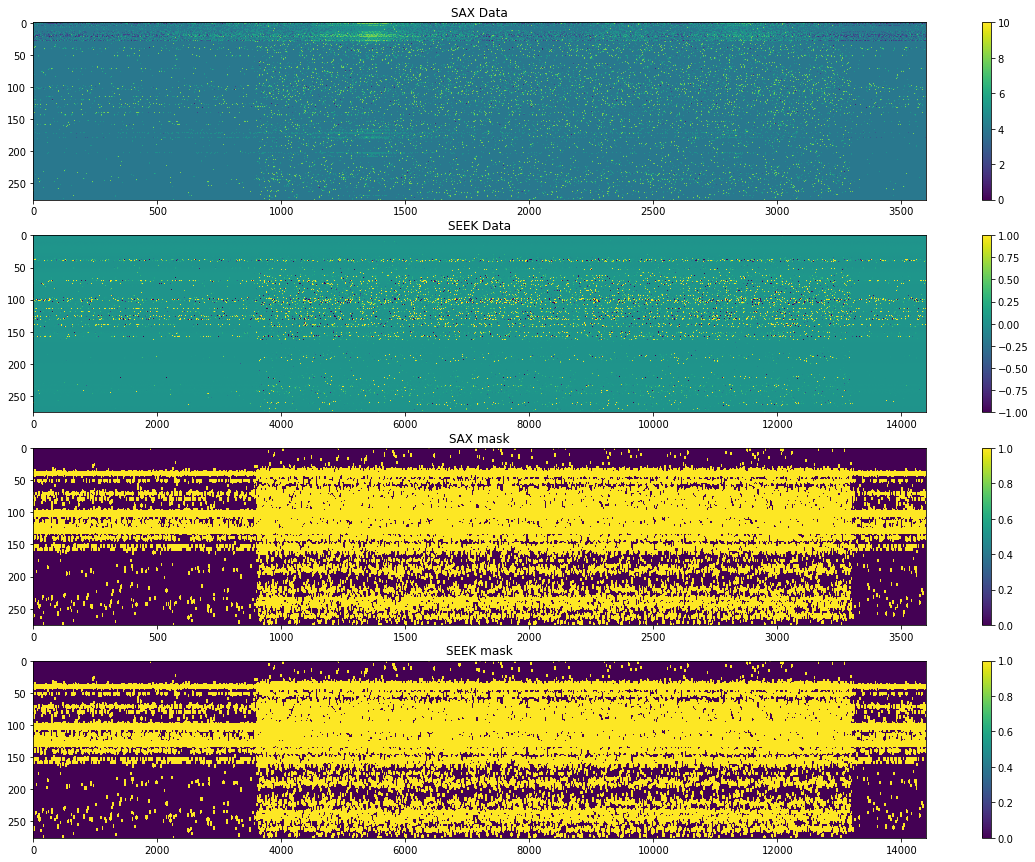

In [60]:
print(data.shape)
fig, ax = plt.subplots(4,1,figsize=(20,15))
img=ax[0].imshow(sax_data, aspect="auto",vmin=0,vmax=10)
ax[0].set_title('SAX Data')
plt.colorbar(img,ax=ax[0])

img=ax[1].imshow(data/data.std(), aspect="auto",vmin=-0.1e1,vmax=0.1e1)
ax[1].set_title('SEEK Data')
plt.colorbar(img,ax=ax[1])

img=ax[2].imshow(sax_mask>0.9, aspect="auto")
ax[2].set_title('SAX mask')
plt.colorbar(img,ax=ax[2])

img=ax[3].imshow(mask, aspect="auto")
ax[3].set_title('SEEK mask')
plt.colorbar(img,ax=ax[3])


#plt.imshow(data,aspect='auto')

In [55]:
data.std()

1998.8962901297509